# HPC Mini-Challenge 2 - Beschleunigung in Data Science
#### FHNW - FS2022

Original von S. Suter, angepasst für das HS22 von S. Marcin

### Ressourcen
* HPC mit Python – days 1-2 ([Videos](https://www.youtube.com/playlist?list=PL1tk5lGm7zvSC4rLm5Y71372R1Yxl2Dg_), [Github](https://github.com/eth-cscs/PythonHPC)), 2020:
    - JupyterLab Tutorial (z.B. GPU Ressourcen)
    - Introduction
    - Vectorization
    - Profiling
    - JIT Numba CPU 1 + 2
    - Siehe auch aktuelles Tutorial von 2021

Abgabe von: <font color='blue'>Florin Barbisch</font>


## Ausgangslage/Problemstellung


Das menschliche Gehirn verliert mit zunehmendem Alter an Funktion. Ein Teil davon ist "gesundes Altern", d.h. es passiert bei jedem Menschen. Ein relativ großer Prozentsatz der alternden Bevölkerung erlebt jedoch auch einen kognitiven Rückgang, der extremer ist als bei anderen. Eine mildere Version davon wird als 'leichte kognitive Beeinträchtigung' (MCI) bezeichnet, bei der die Person grösstenteils noch funktionieren kann. Bei einem Teil der MCI-Patienten schreitet die Krankheit fort und führt zu Demenz bzw. Alzheimer. In diesem Projekt liegen uns MRI-Bilder des Gehirns von Alzheimerpatienten vor. Im spezifischen analysieren wir die Entwicklung von Alzheimer-Patienten anhand von MRI-Bildern, welche über eine bestimmte Zeit zur Verfügung stehen. Es stellt sich die Frage, wie gut sich die Veränderungen des Krankheitsbildes mittels Korrelationen über die Bildanalyse zeigen lassen. Zur Analyse sind Gigabytes von Daten in Form von 3D Gehirn-Scans vorhanden. Die Verarbeitung dieser grossen Datenmengen kann von Komprimierung profitieren.

Das Verständnis von Gedächtnis- und Kognitionsstörungen und die Möglichkeit, den Gesundheitszustand des Gehirns zu erkennen, vorherzusagen und zu überwachen, ist ein gesellschaftlich und wirtschaftlich relevantes Thema der angewandten Wissenschaft. Alle neuen Erkenntnisse, die datenwissenschaftliche Methoden liefern können, werden zur Entwicklung von Lösungen beitragen, mit denen die Gesundheit des Gehirns erkannt, vorhergesagt und überwacht werden kann.

### Daten
[ADNI (Alzheimer's Disease Neuroimaging Initiative)](https://adni.loni.usc.edu/) ist ein internationales Projekt zur Erfassung von Daten über die Alzheimer-Krankheit und andere verwandte Gehirnerkrankungen, die zu einem kognitiven Abbau führen. Die Initiative wurde mit grossem Enthusiasmus aufgenommen, und viele Mitarbeiter aus der ganzen Welt haben Daten zur Verfügung gestellt, die sie in ihren eigenen Forschungsteams gesammelt haben. Die ADNI-Initiative ist ein öffentliches (gemeinnütziges) Projekt, da viele Forschungseinrichtungen auf der ganzen Welt mit Steuergeldern dazu beigetragen haben. Das bedeutet zwei Dinge: 1) Die Daten stehen uns für Forschungs- und Bildungszwecke zur Verfügung, 2) wir dürfen die Daten nicht an andere weitergeben oder kommerzialisieren.



***Wichtig!*** Die Studierenden dürfen die Daten nur für Forschungszwecke verwenden und erhalten nur einen Beispielsdatensatz. Die ADNI-Daten dürfen nur lokal auf dem Computer oder auf FHNW-Ressourcen wie dem GitLab-Repository, d.h. nicht auf Github, gespeichert werden. Siehe [ADNI Datennutzungsvereinbarung](https://adni.loni.usc.edu/wp-content/uploads/how_to_apply/ADNI_Data_Use_Agreement.pdf).


<img src="images/mri-example.png" alt="MRI example image (coronal slice)" width="150"/> <img src="images/slicing.png" alt="Slicing" width="400"/>

Links: MRI Beispielbild (coronaler Schnitt), rechts: MRI slicing

## Zielsetzung

In dieser Aufgabe sollen die Parallelisierung und Beschleunigung unterschiedlicher Methoden von Bildrekonstruktion basierend auf komprimierten (zerlegten) Daten implementiert, analyisiert und diskutiert werden. Die Rekonstruktion der Daten aus der komprimierten Version soll dabei möglichst in Echtzeit geschehen. 

## Lösungsweg / Vorgehen

Wir lösen diese Aufgabenstellung indem wir die Singulärwertzerlegung (SVD: singular value decomposition) als Kompressionsmethode verwenden (Matrixfaktorisierung). Siehe Abbildungen unten. Um die Rekonstruktion der Daten aus der SVD-Matrixfaktoriseriung möglichst in Echtzeit zu bewerkstelligen, evaluieren wir dafür verschiedene Methoden der Parallelisierung und Beschleunigung in Python. 
* Beschleunigungsvarianten auf der CPU:
    - Numpy Operationen inkl. Broadcasting
    - Numba
    - Threads
* Beschleunigung auf der GPU:
    - Cupy (analog zu Numpy)
    - Numba (analog zu Numba)

<img src="images/svd_reco.png" alt="svd vis" width="300"/> <img src="images/svd.png" alt="svd" width="300"/>

## Daten Zerlegen
### 1.1 Daten laden


In [1]:
import os
import imageio.v2 as imageio
import numpy as np

subfolder = '001'
folders = os.path.join('adni_png', subfolder)

images = np.empty([4,256,170])
idx = 0
names = []
for filename in os.listdir(folders):
    if filename.endswith('.png') and '145' in filename:
        with open(os.path.join(folders, filename), 'r') as f:
            im = imageio.imread(f.name)
            names.insert(idx,f.name[-17:-4])
            images[idx,:,:] = im
            print (names[idx], im.shape)
            idx += 1
            if idx == 4:
                break
            
print(images.shape)

m1-1_slice145 (256, 170)
m1-2_slice145 (256, 170)
m3-1_slice145 (256, 170)
m3-2_slice145 (256, 170)
(4, 256, 170)


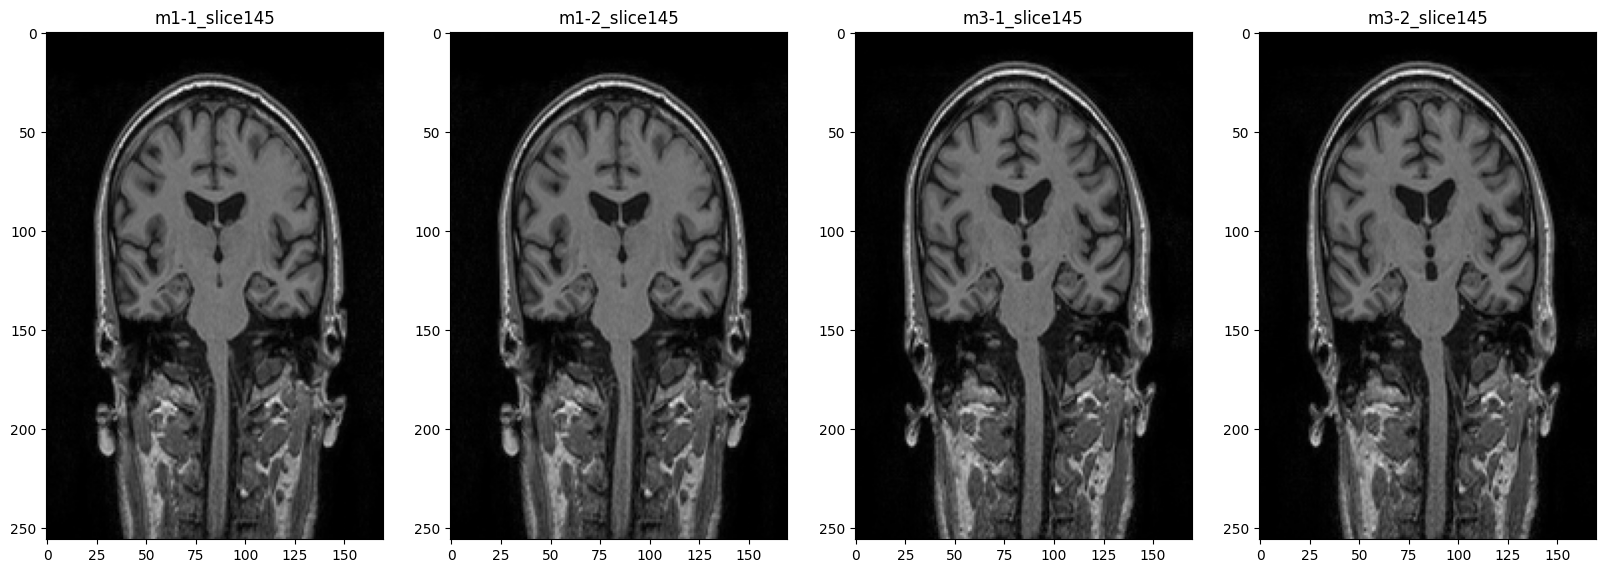

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,10))

for a in range(images.shape[0]):
    ax = fig.add_subplot(1,images.shape[0],a+1)
    ax.imshow(images[a],cmap='gray')
    ax.set_title(names[a])


### 1.2 Daten zerlegen

In [3]:
im = images[0]
im = im -im.min() / im.max() - im.min() # normalize data 
u,s,vt = np.linalg.svd(im, full_matrices=False)

In [4]:
def reconstruct_svd(u,s,vt,k):
    """SVD reconstruction for k components using np.dot()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    reco = np.dot(u[...,:k], np.dot(np.diag(s[:k]), vt[:k,...]))
        
    return reco

In [5]:
from skimage import metrics

# calculate various metrics for the reconstruction quality
def calculate_metrics(im, reco):
    mse = metrics.mean_squared_error(im, reco)
    ssim_score = metrics.structural_similarity(im, reco, data_range=255.0)
    hdist = metrics.hausdorff_distance(im, reco)
    return f"MSE: {mse:.2f}, SSIM {ssim_score:.2f}, HDIST: {hdist:.2f}"


original size:  43520
decomposed to n =  170 , size:  72590
decomposed to n =  140 , size:  59780
decomposed to n =  110 , size:  46970
decomposed to n =  80 , size:  34160
decomposed to n =  50 , size:  21350


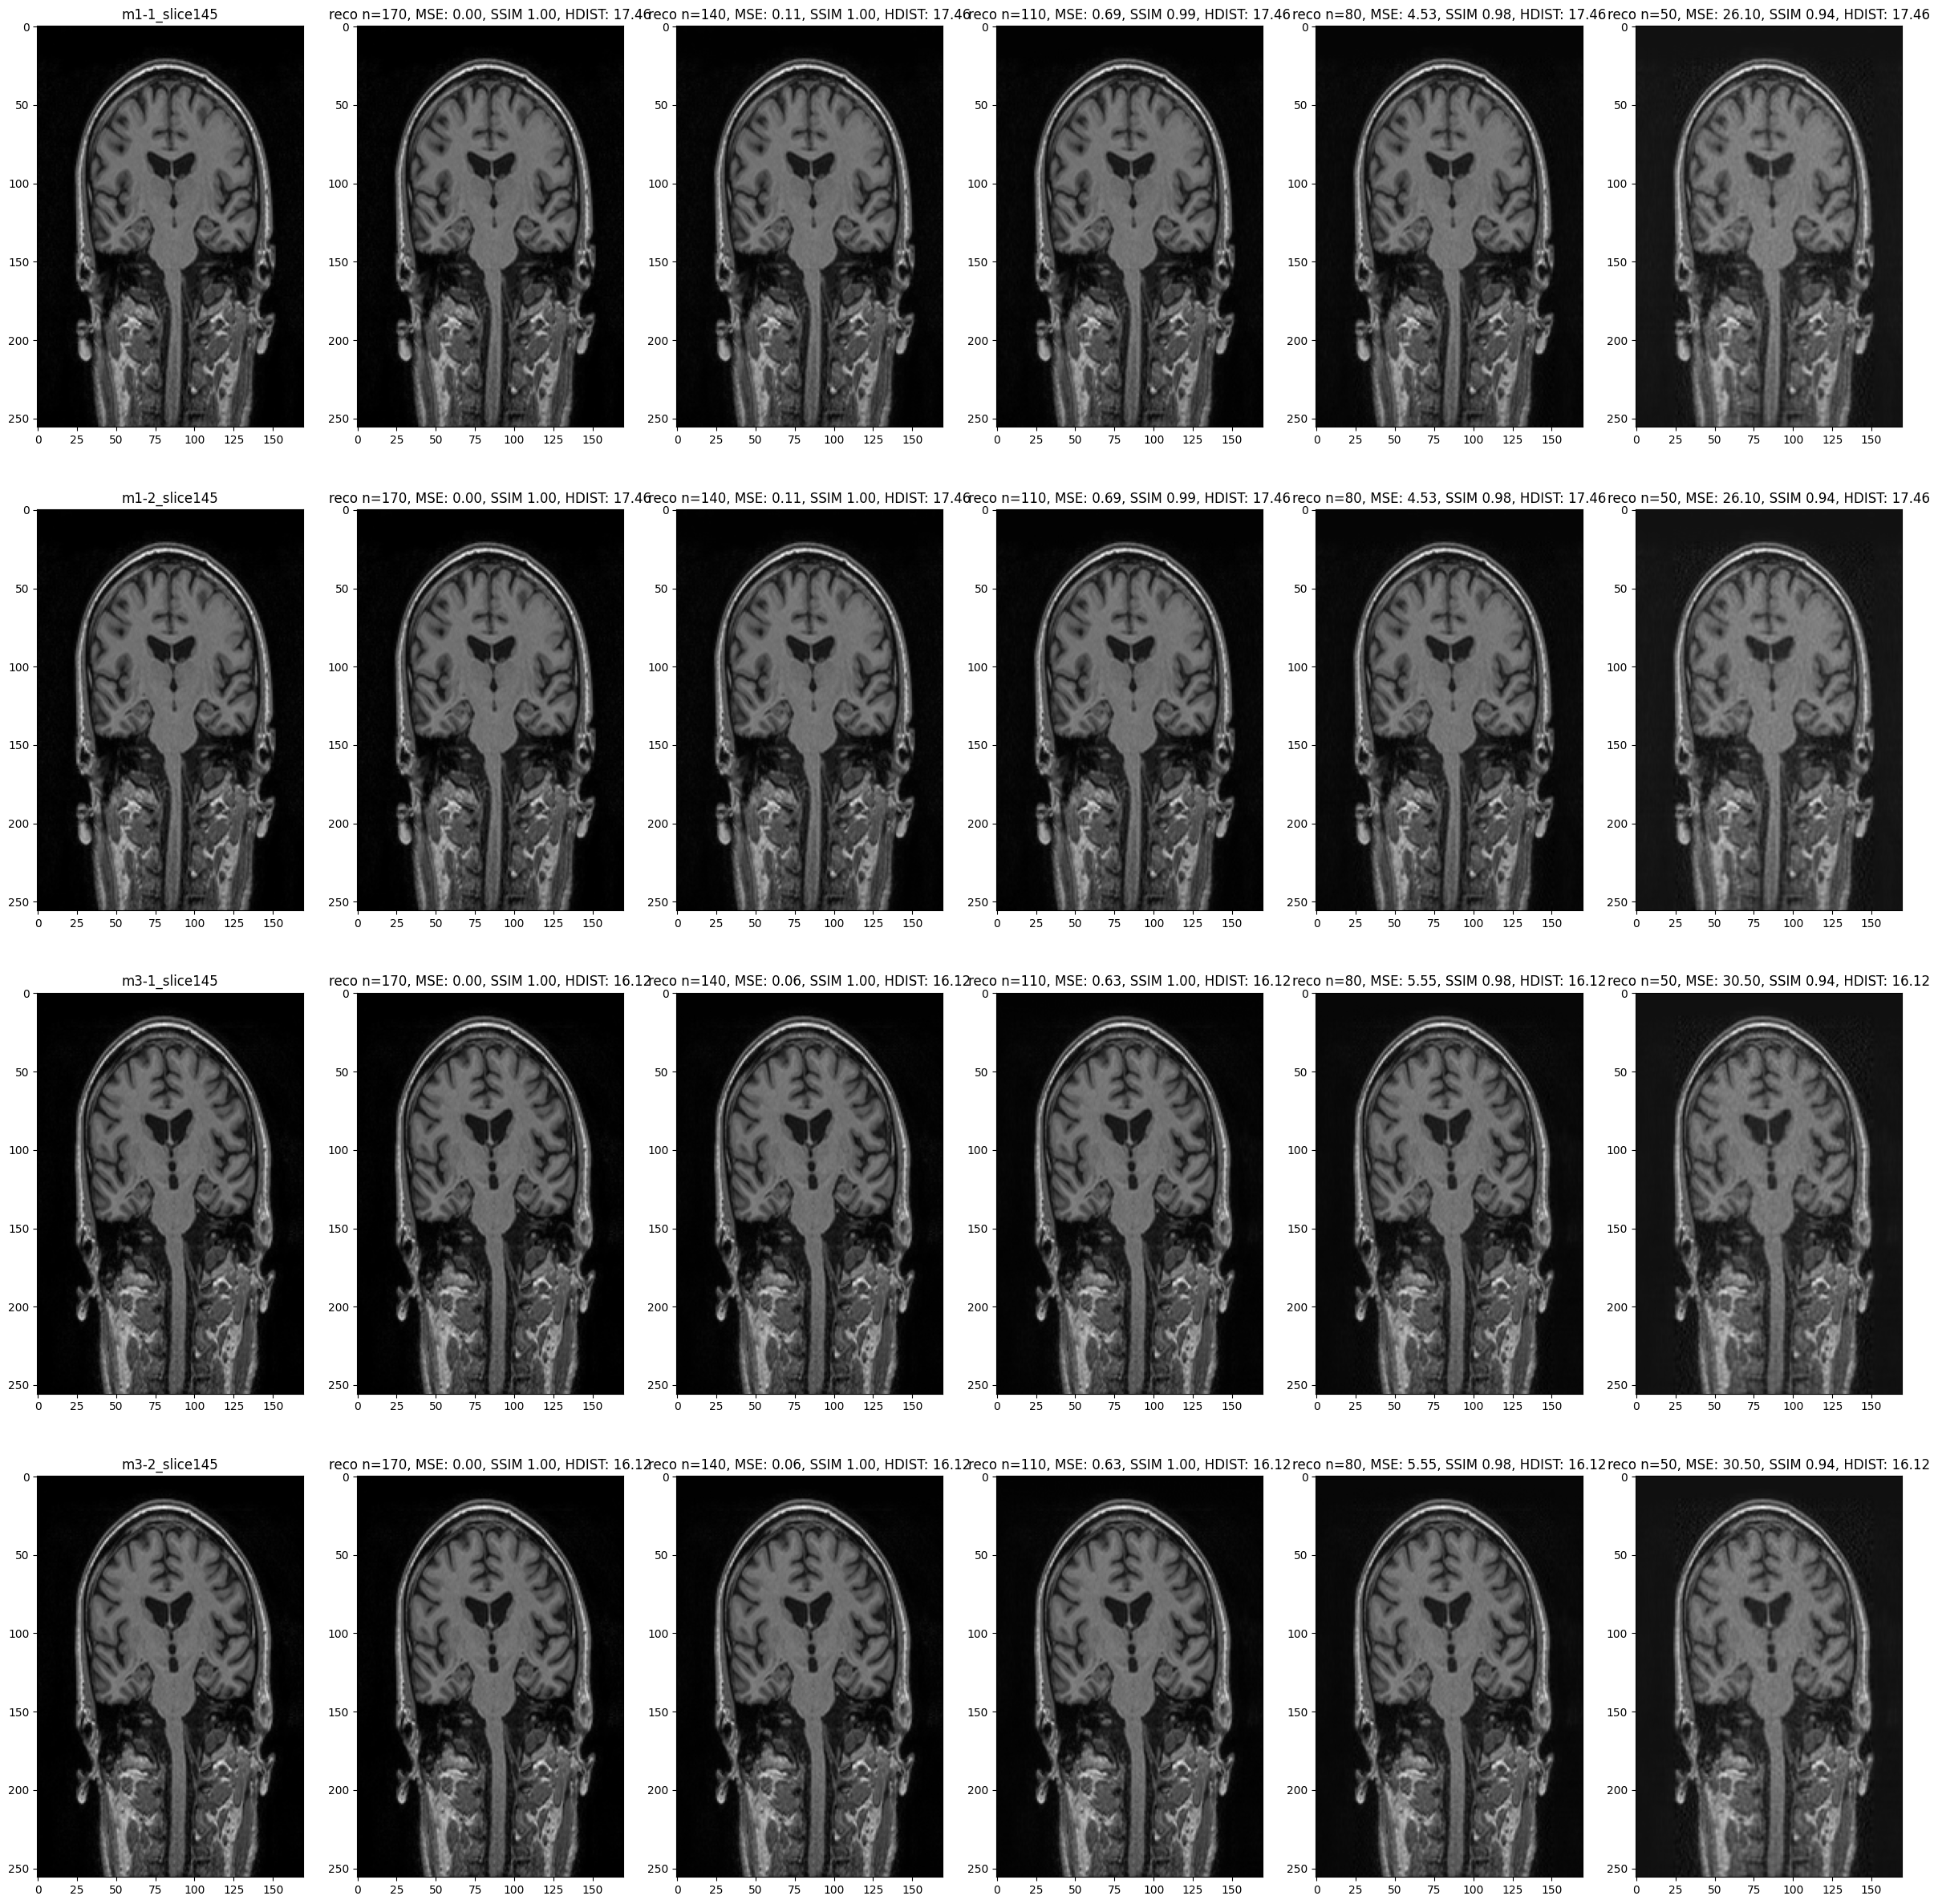

In [6]:
fig, axs = plt.subplots(images.shape[0], 6, figsize=(30,30))

for a in range(images.shape[0]):
    im = images[a]
    im = im -im.min() / im.max() - im.min()    
    u,s,vt = np.linalg.svd(im, full_matrices=False)

    axs[a, 0].imshow(im,cmap='gray')
    axs[a, 0].set_title(names[a])
    
    if (a == 0):
        print('original size: ', im.shape[0]*im.shape[1])
    
    for idx, n in enumerate(range(s.shape[0], 20, -30)):
        reco = reconstruct_svd(u,s,vt,n)
        if (a == 0):
            print('decomposed to n = ', n , ', size: ', u.shape[0] * n + n + vt.shape[0]*n)
    
        axs[a, idx+1].imshow(reco,cmap='gray')
        axs[a, idx+1].set_title('reco n=' + str(n) + ', ' + calculate_metrics(im, reco))
    

### 2 Rekonstruktionsvarianten
Siehe Bilder in der Einführung (Teil: Vorgehen).

In [7]:
# helper function to visualze reconstruction
def plot_reco(reco, k):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(reco,cmap='gray')
    ax.set_title('reco with ' + str(k)+ ' components')

#### 2.1 For-Loops
Rekonstruiere nun die zerlegte SVD Matrix mittels For-Loops gemäss Formel B.4 (oben). Rekonstruiere nur die ersten $k$ Komponenten der SVD-Matrixfaktorisierung $U, S, V^T$, wobei $U \in \mathbb{R}^{MxN}$, $S \in \mathbb{R}^{N}$, und  $V^T \in \mathbb{R}^{NxN}$. 

Implementiere dafür folgende drei Funktionen - jeweils mit 3, 2 bzw. 1 For-Loop:

In [8]:
def reconstruct_svd_for_loops3(u,s,vt,k):
    """SVD reconstruction for k components using 3 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = np.zeros((u.shape[0], vt.shape[1]))
    for i in range(u.shape[0]):
        for j in range(vt.shape[1]):
            for l in range(k):
                reco[i,j] += u[i,l] * s[l] * vt[l,j]
    ### END SOLUTION

    return reco

In [9]:
def reconstruct_svd_for_loops2(u,s,vt,k):
    """SVD reconstruction for k components using 2 for-loops
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = np.zeros((u.shape[0], vt.shape[1]))

    for i in range(u.shape[0]):
        for j in range(vt.shape[1]):
            reco[i,j] = np.dot(u[i,:k], s[:k] * vt[:k,j])
    ### END SOLUTION

    return reco

In [10]:
def reconstruct_svd_for_loops1(u,s,vt,k):
    """SVD reconstruction for k components using 1 for-loop and np.outer()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = np.zeros((u.shape[0], vt.shape[1]))

    for i in range(u.shape[0]):
        reco[i,:] = ((u[i,:k] * s[:k]) @ vt[:k,:])
    ### END SOLUTION

    return reco

#### 2.2 Einstein Summation
Implementiere nun eine möglichst schnelle Rekonstruktionsvariante mittels `np.einsum()` gemäss folgender Funktion:

In [11]:
def reconstruct_svd_einsum1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast
    # What is einsum: https://stackoverflow.com/questions/26089893/understanding-numpys-einsum
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = np.einsum("mk,k,kn->mn", u[:,:k], s[:k], vt[:k,:])
    ### END SOLUTION

    return reco

#### 2.3 Broadcasting
Implementiere nun zwei Rekonstruktionsvarianten mittels Broadcasting.

Links:
- https://machinelearningmastery.com/broadcasting-with-numpy-arrays/
- https://numpy.org/doc/stable/user/basics.broadcasting.html
- https://eli.thegreenplace.net/2015/broadcasting-arrays-in-numpy/
- https://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc

In [12]:
def reconstruct_svd_broadcast1(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 1
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    # TODO is @ really broadcasting? 
    reco = u[:,:k] * s[:k] @ vt[:k,:]
    ### END SOLUTION

    return reco

In [13]:
def reconstruct_svd_broadcast2(u,s,vt,k):
    """SVD reconstruction for k components using broadcast variant 2
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    # TODO is @ really broadcasting?
    reco = u[:,:k] @ (s[:k].reshape((-1,1)) * vt[:k,:])
    ### END SOLUTION

    return reco


#### 2.4 Vergleich der Resultate
Vergleiche die Resultate der Implementierungen anhand eines Beispielbildes. Sind die Rekonstruktionen nahezu gleich? Wie sieht es mit der Rekonstruktionsgeschwindigkeit aus - abhängig von der Anzahl rekonstruierter Komponenten?

In [ ]:
### BEGIN SOLUTION
plot_reco(reconstruct_svd_for_loops3(u,s,vt,30), 30)
plot_reco(reconstruct_svd_for_loops2(u,s,vt,30), 30)
plot_reco(reconstruct_svd_for_loops1(u,s,vt,30), 30)

plot_reco(reconstruct_svd_einsum1(u,s,vt,30), 30)

plot_reco(reconstruct_svd_broadcast1(u,s,vt,30), 30)
plot_reco(reconstruct_svd_broadcast2(u,s,vt,30), 30)
### END SOLUTION

Die Rekonstruirten Bildern sind alle gleich.

In [ ]:
### BEGIN SOLUTION
import timeit
import pandas as pd
from tqdm import tqdm

methods = [reconstruct_svd_for_loops3, reconstruct_svd_for_loops2, reconstruct_svd_for_loops1, reconstruct_svd_einsum1, reconstruct_svd_broadcast1, reconstruct_svd_broadcast2]

ks = [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
reconstruction_times = []
for method in methods:
    for k in tqdm(ks, desc=f"{methods.index(method)}/{len(methods)}: {method.__name__}: "):
        # measure time for reconstruction
        elapsed = timeit.timeit(lambda: method(u,s,vt,k), number=10)
        reconstruction_times.append((method.__name__, k, elapsed))

df = pd.DataFrame(reconstruction_times, columns=["method", "k", "time"])
df.sample(n=5)
### END SOLUTION

In [ ]:

# plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x="k", y="time", hue="method", data=df)
plt.yscale("log")
plt.xlabel("number of reconstructed singular components [k]")
plt.ylabel("time [s]")

plt.show()

# only plot einsum and loops3 for better visibility
# TODO beschriften
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(x="k", y="time", hue="method", data=df[df["method"].isin(["reconstruct_svd_einsum1"])], ax=axs[0])
sns.lineplot(x="k", y="time", hue="method", data=df[df["method"].isin(["reconstruct_svd_for_loops3"])], ax=axs[1])

#### 2.5 Interpretation der Resultate

Welche der Implementierungen war am schnellsten? Was waren deine Beobachtungen während  der Implementierung? Wo können solche Optimierungen sonst noch eingesetzt werden? Diskutiere in ca. 150-200 Wörtern.

Die beiden Broadcast-Methoden waren am schnellsten. Interessant finde ich die Sprünge der Broadcast-Methoden von 20 auf 30. Hier brauchten die Methoden plötzlich circa 10-mal so viel Zeit zur Berechnung. Auch der Sprung von loop-1 von 40 auf 50 ist interessant. Hier brauchten die Methode aber eher 100-mal so viel Zeit zur Berechnung.

Im Plot ist zu sehen, dass die Broadcast, loop-1 und loop-2 Methoden unabhängig von k sind (ausser der Sprünge). Bei den Methoden loop-3 und einsum ist dies nicht der Fall. Hier ist die Rechenzeit abhängig von k und zwar linear (auch wenn man aufgrund der drei For-Loops von einer qubischen Abhängigkeit ausgehen könnte). Die Kurven haben einen so ähnlichen Verlauf, weil die Einsum-Methode gleich vorgeht, aber die For-Loops in C geschrieben sind. Weil For-Loops in Python äusserts ineffizient sind, ist die Einsum-Methode auch so schnell.

TODO erst 143 wörter, und Wo können solche Optimierungen sonst noch eingesetzt werden?

### 3 Parallelisierung mittels Numba

Implementiere nun eine möglichst schnelle Rekonstruktionsvariante des SVDs mittels Numba. Ist es möglich, den Code mit Numba zu beschleunigen? Führe dazu eine Diagnostik aus. Wenn ja, was ist der Speedup-Faktor und welche(r) Teil(e) konnte(n) parallelisiert werden? Falls nein, was sind die Gründe, weshalb es sich nicht parallelisieren lässt? Lassen sich verschachtelte Schleifen parallelisieren? Warum? Diskutiere in ca. 150-200 Wörtern, wann und warum sich Numba für die Parallelisierung eignet - anhand deines Beispiels.

Beachte:
* Beim ersten Mal Ausführen des Codes wird die Zeit des Kompilierens mit eingerechnet.
* Numba eignet sich gut für For-Schleifen

In [ ]:
import numba

### BEGIN SOLUTION
@numba.njit
### END SOLUTION
def reconstruct_svd_numba(u,s,vt,k):
    """SVD reconstruction for k components using numba
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    
    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
### BEGIN SOLUTION
    reco = np.zeros((u.shape[0], vt.shape[1]))
    for i in range(u.shape[0]):
        for j in range(vt.shape[1]):
            for l in range(k):
                reco[i,j] += u[i,l] * s[l] * vt[l,j]
# TODO macht es sinn die loop-3 zu nehmen? oder sollte ich broadcast nehmen? oder beides? 
# TODO was ist mit diagnostik gemeint?
### END SOLUTION

    return reco

In [ ]:
### BEGIN SOLUTION
# quick test
#plot_reco(reconstruct_svd_numba(u,s,vt,30), 30)
#plt.show()

# drp reconstruct_svd_numba reconstruction_times
reconstruction_times_w_numba = reconstruction_times.copy()

# measure using timeit
for k in ks:
    elapsed = timeit.timeit(lambda: reconstruct_svd_numba(u,s,vt,k), number=10)
    reconstruction_times_w_numba.append(("reconstruct_svd_numba", k, elapsed))


df = pd.DataFrame(reconstruction_times_w_numba, columns=["method", "k", "time"])

sns.lineplot(x="k", y="time", hue="method", data=df[df["method"].isin(["reconstruct_svd_numba", "reconstruct_svd_einsum1", "reconstruct_svd_for_loops3"])])
plt.yscale("log")
# TODO beschriften
plt.show()


# calculate speedup from for_loops3
numba_times = df[df["method"] == "reconstruct_svd_numba"]["time"].values
for_loops3_times = df[df["method"] == "reconstruct_svd_for_loops3"]["time"].values

speedup = for_loops3_times / numba_times
# plot speedup
sns.lineplot(x=ks, y=speedup)
plt.ylim(0, 1000)
plt.axhline(500, color="black", linestyle="--")
# TODO beschriften


### END SOLUTION

Wie ich erwartet habe, kann numba die for-loops nach C kompilieren und dann die gleiche Performance wie die Einsum-Methode erreichen. Die Einsum-Methode ist noch ein ticken schneller, wahrscheinlich weil die numba Kompilierung nicht ganz an die in C geschrieben und von Menschen optimierte einsum-methode in Python. Dennoch ist mit numba ein Speedup von 500x möglich.

TODO mehr wörter

### 4 Parallelisierung mit Threads

Als nächstes Parallelisieren wir die Rekonstruktion der SVD zerlegten Matrizen mittels unterschiedlichen Thread-Varianten.

Links:
* Threading in Python ([Videokurs](https://realpython.com/courses/threading-python/), [Blogartikel](https://realpython.com/intro-to-python-threading/), [Quiz](https://realpython.com/quizzes/python-threading/)), RealPython
* https://github.com/eth-cscs/PythonHPC/tree/master/intro
* Slides vom Kurs kvanc zum Thema IPC mittels Python

#### 4.1 Einzelne Threads auf einer CPU

Implementiere eine Funktion, welche ein Rekonstruktionsschritt in Thread rekonstruiert. Wähle selbst welchen Schritt du mittels Threading implementierst. Verwende dabei geeignete Lock-Mechanismen. Verwende vor und nach den Lock-Mechanismen geeignete Print/Log-Statements und verwende unterschiedliche Farben der Print-Statements für die Threads. Validiere dein Ergebnis der Rekonstruktion indem du mehrere Threads für einzelne Rekonstruktionsschritte aufruftst.

In [14]:
### BEGIN SOLUTION
import threading
import time


thread_colors = {
    'red': '\033[91m', 
    'green': '\033[92m',
    'yellow': '\033[93m',
    'blue': '\033[94m'
}


class Reconstruction1:

    def __init__(self, size):
        self._reco = np.zeros(size)
        self._lock = threading.Lock()

    def add(self, i, row, thread_name):
        print_color = thread_colors[thread_name]
        print(print_color + f"thread {thread_name}: row {i:03}: about to lock")
        # TODO why do I need locks here? Because the operations here are atomic, right?
        with self._lock:
            print(print_color + f"thread {thread_name}: row {i:03}: locked")
            self._reco[i] = row
            time.sleep(0.001) # else the output is pretty boring
        print(print_color + f"thread {thread_name}: row {i:03}: unlocked")


def reconstruct_svd_threaded1(u,s,vt,k, reco, offset, step):
    """SVD reconstruction for k components using 1 for-loop and np.outer()
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    reco: Reconstruction object to store the reconstruction
    offset: offset for for-loop
    step: step size for for-loop
    print_color: color for print statement
    """
    for i in range(offset, u.shape[0], step):
        row = ((u[i,:k] * s[:k]) @ vt[:k,:])
        reco.add(i, row, threading.current_thread().name)
### END SOLUTION

thread red: row 000: about to lock
thread red: row 000: locked
thread green: row 001: about to lock
thread yellow: row 002: about to lock
thread blue: row 003: about to lock
thread red: row 000: unlocked
thread red: row 004: about to lock
thread red: row 004: locked
thread red: row 004: unlocked
thread red: row 008: about to lock
thread yellow: row 002: locked
thread yellow: row 002: unlocked
thread yellow: row 006: about to lock
thread blue: row 003: locked
thread blue: row 003: unlocked
thread blue: row 007: about to lock
thread green: row 001: locked
thread green: row 001: unlocked
thread green: row 005: about to lock
thread red: row 008: locked
thread red: row 008: unlocked
thread red: row 012: about to lock
thread yellow: row 006: locked
thread yellow: row 006: unlocked
thread yellow: row 010: about to lock
thread blue: row 007: locked
thread blue: row 007: unlocked
thread blue: row 011: about to lock
thread green: row 005: locked
thread green: row 005: unlocked
thread green: row 

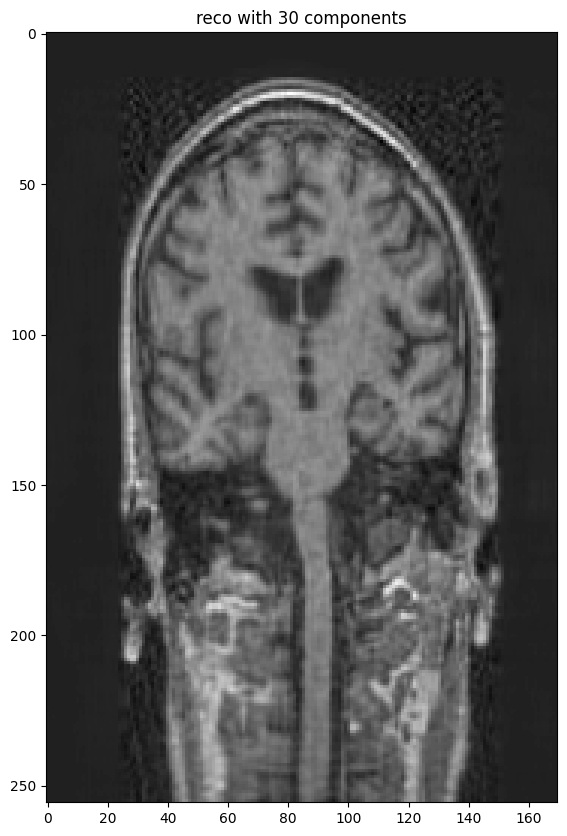

In [15]:
### BEGIN SOLUTION

n_threads = len(thread_colors)
threads = []
reco = Reconstruction1((u.shape[0], vt.shape[1]))
for i in range(n_threads):
    t = threading.Thread(target=reconstruct_svd_threaded1, args=(u,s,vt,30, reco, i, n_threads), name=list(thread_colors.keys())[i])
    t.start()
    threads.append(t)

for t in threads:
    t.join()

# display results
plot_reco(reco._reco, 30)

### END SOLUTION

color1 = '\033[91m'  # red
color2 = '\033[92m'  # green
color3 = '\033[93m'  # yellow
color4 = '\033[94m'  # blue

#### 4.2 Bonus: Thread-Pool-Executor

Rufe zum Vergleich die unabhängige Rekonstruktionsschritte mittels eines Thread-Pool-Executors auf.

thread_0: row 000: about to lock
thread_0: row 000: locked
thread_1: row 001: about to lock
thread_2: row 002: about to lock
thread_3: row 003: about to lock
thread_0: row 000: unlocked
thread_0: row 004: about to lock
thread_1: row 001: locked
thread_1: row 001: unlocked
thread_1: row 005: about to lock
thread_2: row 002: locked
thread_2: row 002: unlocked
thread_2: row 006: about to lock
thread_2: row 006: locked
thread_2: row 006: unlocked
thread_2: row 007: about to lock
thread_0: row 004: locked
thread_0: row 004: unlocked
thread_0: row 008: about to lock
thread_1: row 005: locked
thread_1: row 005: unlocked
thread_1: row 009: about to lock
thread_3: row 003: locked
thread_3: row 003: unlocked
thread_3: row 010: about to lock
thread_2: row 007: locked
thread_2: row 007: unlocked
thread_2: row 011: about to lock
thread_0: row 008: locked
thread_0: row 008: unlocked
thread_0: row 012: about to lock
thread_1: row 009: locked
thread_1: row 009: unlocked
thread_1: row 013: about to loc

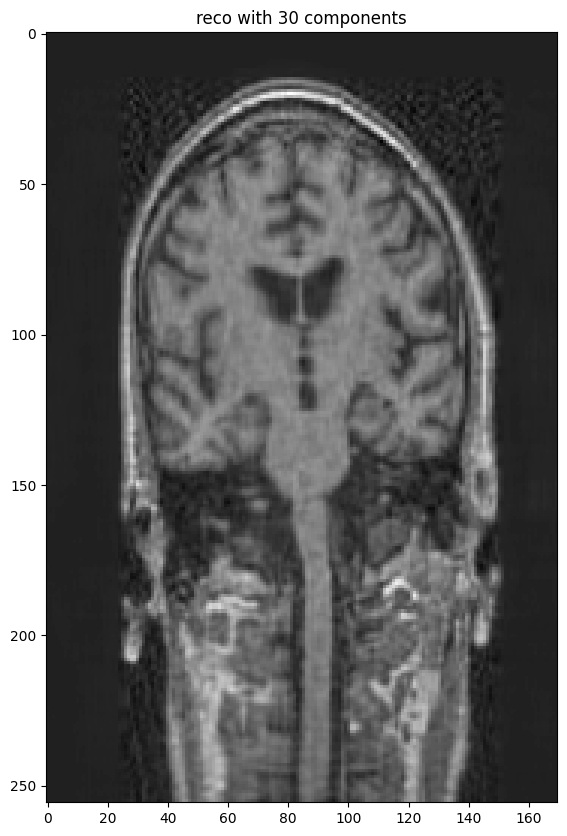

In [18]:
### BEGIN SOLUTION
def reconstruct_svd_threaded2(u,s,vt,k, reco, i):
    """SVD reconstruction for k components for the i-th row
    
    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components
    reco: Reconstruction object to store the reconstruction
    i: row index

    Ouput:
    (n) numpy array reconstructed row
    """
    row = ((u[i,:k] * s[:k]) @ vt[:k,:])
    reco.add(i, row, threading.current_thread().name)



thread_colors = ['\033[91m', '\033[92m', '\033[93m', '\033[94m']


class Reconstruction2:

    def __init__(self, size):
        self._reco = np.zeros(size)
        self._lock = threading.Lock()

    def add(self, i, row, thread_name):
        # get the last character of the thread name as integer
        thread_index = int(thread_name[-1])
        print_color = thread_colors[thread_index]
        print(print_color + f"{thread_name}: row {i:03}: about to lock")
        # TODO why do I need locks here? Because the operations here are atomic, right?
        with self._lock:
            print(print_color + f"{thread_name}: row {i:03}: locked")
            self._reco[i] = row
            time.sleep(0.001) # else the output is pretty boring
        print(print_color + f"{thread_name}: row {i:03}: unlocked")


import concurrent.futures

with concurrent.futures.ThreadPoolExecutor(max_workers=4, thread_name_prefix="thread") as executor:
    reco = Reconstruction2((u.shape[0], vt.shape[1]))
    futures = []
    for i in range(u.shape[0]):
        futures.append(executor.submit(reconstruct_svd_threaded2, u,s,vt,30, reco, i))

    # wait for all futures to finish
    for f in concurrent.futures.as_completed(futures):
        pass

    # display results
    plot_reco(reco._reco, 30)

### END SOLUTION

#### 4.3 Bonus: Threads auf mehreren CPUs

Verwende anstelle von Threading Multiprocessing damit die Threads auf mehrere CPUs verteilt werden.

Links:
* Concurrency [Blog](https://realpython.com/python-concurrency/), [Quiz](https://realpython.com/quizzes/python-concurrency/), RealPython


In [22]:
### BEGIN SOLUTION
import multiprocessing

class Reconstruction3:

    def __init__(self, size):
        self._reco = np.zeros(size)
        self._lock = multiprocessing.Lock()

    def add(self, i, row, thread_name):
        # get the last character of the thread name as integer
        thread_index = int(thread_name[-1])
        print_color = thread_colors[thread_index]
        print(print_color + f"{thread_name}: row {i:03}: about to lock")
        # TODO why do I need locks here? Because the operations here are atomic, right?
        with self._lock:
            print(print_color + f"{thread_name}: row {i:03}: locked")
            self._reco[i] = row
            time.sleep(0.001) # else the output is pretty boring
        print(print_color + f"{thread_name}: row {i:03}: unlocked")



with multiprocessing.Pool(processes=4) as pool:
    # TODO reicht nicht. Das Array muss ein Multiprocessing Array sein und ich weiss nicht ob es sich lohnt die Klasse auch Multiprocessing zu machen
    # TODO auch weiss ich nicht, ob es sich lohnt print statements in die Klasse zu packen
    # TODO vllt reicht es auch, wenn ich die ergebnisse am schluss in ein array schreibe
    reco = Reconstruction3((u.shape[0], vt.shape[1]))
    for i in range(u.shape[0]):
        pool.map(reconstruct_svd_threaded2, [(u,s,vt,30, reco, i)])

    # wait for all futures to finish
    for f in futures:
        f.wait()

    # display results
    plot_reco(reco._reco, 30)


### END SOLUTION

RuntimeError: Lock objects should only be shared between processes through inheritance

#### 4.4 Analyse

1. Macht es in diesem Beispiel Sinn Threads zu benutzen? Wann ist es sinnvoll Threads zu benutzen? Beschreibe in 2-3 Sätzen warum. 

<font color='blue'>Antwort hier eingeben</font>

2. Könnten in diesem Beispiel auch andere Code-Teile auf mehreren Threads aufgerufen werden? Welche würden sich eignen? Welche nicht? Beschreibe in 2-3 Sätzen warum. 

<font color='blue'>Antwort hier eingeben</font>

3. Was sind die Unterschiede (auch bzgl. Leistung) der manuellen Ausführung des Threadings vs. dem Benutzen eines Thread-Pool-Executors oder von Multiprocessing?

<font color='blue'>Antwort hier eingeben</font>